# Intergalactic propagation of UHECRs including magnetic fields

This notebook exemplifies how to simulate the propagation of UHECRs considering the effects of magnetic fields. 

Because this type of simulation is usually very time-consuming, presented is a simple scenario of just one astrophysical object with a jet pointing at Earth.

The magnetic field is assumed to be turbulent. In reality, magnetic-field distributions from cosmological simulations would be more adequate. Some of these models are publicly available:
- [Hackstein et al. 2018](https://arxiv.org/abs/1710.01353)
- [Alves Batista et al. 2017](https://arxiv.org/abs/1704.05869)

They can be downloaded from [here](https://crpropa.github.io/CRPropa3/pages/AdditionalResources.html).


### Assembling the 3D simulation

Here the simulation is assembled.

Note that no redshift information has been provided. The reason for that is that, in order to consider cosmological effects, a 4D observer would be needed, greatly increasing the cost of simulation.

The break conditions used here are the usual `MinimumEnergy` and `MaximumTrajectoryLength`. Additionally, a new one is used for the first time, `SphericalBoundary`, which inactivates particles leaving this spherical surface.

The size of the observer is chosen to be 200 kpc. A smaller observer would receive fewer events. 
Considering that the source is 4 Mpc away, this is reasonable. However, for real studies, convergence tests have to be run to find a suitable size which compromises speed and detection rate.

In [ ]:
import numpy as np
from crpropa import *


def simulate(distance, field, A, Z, nEvents = 10000):
	# general simulation parameters
	jetOpening = np.radians(10.) 
	energyRange = (0.9 * EeV, 1000 * EeV)
	sourceDirection = Vector3d()
	sourceDirection.setRThetaPhi(1, np.radians(309.5 - 180.), np.radians(19.41 - 90.))
	sourcePosition = sourceDirection * (- distance)
	cmb = CMB()
	ebl = IRB_Gilmore12()
	outputFile = 'sim/06-sim3D-D_%.0eMpc-B_%2.1eT-A_%02i_Z_%02i.txt' % (distance / Mpc, field, A, Z)

	# magnetic field
	randomSeed = 2308 # to ensure reproducibility of the simulation
	scaleMinimum = 100 * kpc
	scaleMaximum = 10 * Mpc
	spectralIndex = 5. / 3. # Kolmogorov
	gridOrigin = Vector3d(0, 0, 0)
	gridSpacing = 50 * kpc
	gridCells = 200
	turbulentSpectrum = SimpleTurbulenceSpectrum(field, scaleMinimum, scaleMaximum, spectralIndex)
	gridProperties = GridProperties(gridOrigin, gridCells, gridSpacing)
	magneticField0 = SimpleGridTurbulence(turbulentSpectrum, gridProperties, randomSeed)
	magneticField1 = PeriodicMagneticField(magneticField0, Vector3d(-400, -400, -400) * Mpc)
	magneticField = PeriodicMagneticField(magneticField1, Vector3d(-400, -400, -400) * Mpc)
	coherenceLength = magneticField0.getCorrelationLength() / Mpc


	# source distribution: uniform with power-law spectrum
	# position = SourcePosition(Vector3d(distance, 0, distance))
	position = SourcePosition(sourcePosition)
	direction = SourceEmissionCone(sourceDirection, jetOpening) 
	energySpectrum = SourcePowerLawSpectrum(*energyRange, -1)
	particleType = SourceParticleType(nucleusId(A, Z))
	source = Source()
	source.add(position)
	source.add(direction)
	source.add(energySpectrum)
	source.add(particleType)

	# output
	outputType = Output.Event3D
	output = TextOutput(outputFile, outputType)
	output.disable(output.CandidateTagColumn)
	output.setEnergyScale(eV)
	output.setLengthScale(Mpc)

	# observer 
	observerSurface = Sphere(Vector3d(0, 0, 0), 200 * kpc)
	observerType = ObserverSurface(observerSurface)
	observer = Observer()
	observer.add(observerType)
	observer.onDetection(output)

	# interactions
	pdCMB = PhotoDisintegration(cmb)
	pdEBL = PhotoDisintegration(ebl)
	pppCMB = PhotoPionProduction(cmb)
	pppEBL = PhotoPionProduction(ebl)
	eppCMB = ElectronPairProduction(cmb)
	eppEBL = ElectronPairProduction(ebl)
	nd = NuclearDecay()
	processes = [pdCMB, pdEBL, pppCMB, pppEBL, eppCMB, eppEBL, nd]

	# propagator: one-dimensional
	propagator = PropagationBP(magneticField, 1e-3, 10 * kpc, 1 * Mpc)

	# break conditions
	breakTrajectory = MaximumTrajectoryLength(4000 * Mpc)
	breakEnergy = MinimumEnergy(energyRange[0])
	breakBoundary = SphericalBoundary(Vector3d(0, 0, distance), 400 * Mpc) # stop tracking particles that leave the sphere of 400 Mpc around the source

	# assemble simulation components
	sim = ModuleList()
	sim.add(propagator)
	for interaction in processes:
		sim.add(interaction)
	sim.add(observer)
	sim.add(breakEnergy)
	sim.add(breakTrajectory)
	sim.add(breakBoundary)
	sim.setShowProgress(True)
	sim.run(source, nEvents, True)

	output.close()

	return outputFile


outputFile1 = simulate(3.7 * Mpc, 1e-13,  1, 1, nEvents = 200000)
outputFile2 = simulate(3.7 * Mpc, 1e-15,  1, 1, nEvents = 200000)
outputFile3 = simulate(3.7 * Mpc, 1e-13, 14, 7, nEvents = 200000)
outputFile4 = simulate(3.7 * Mpc, 1e-15, 14, 7, nEvents = 200000)

### Helper functions

Functions are provided for reading the simulations, computing the spectrum, obtaining the distribution of deflections, and computing the arrival directions. This includes the reweighting procedure.

Deflections are defined as 
$$
\delta = \cos^{-1} \left( \vec{p} \cdot \vec{p}_0 \right) \,,
$$
where $\vec{p}$ is the arrival momentum of the event, and $\vec{p}_0$ the momentum (or direction) of emission.

The arrival directions are calculated minding CRPropa's and Matplotlib's conventions.  

Co-latitude:  
- CRPropa: $\theta \in [0, \pi]$, with 0 towards the z direction  
- Matplotlib: $\theta \in [-\pi/2, \pi/2]$  
Longitude:  
- CRPropa: $\phi \in [-\pi, \pi]$, with 0 towards the x direction  
- Matplotlib: $\phi \in [0, \pi]$  

In [79]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output.
	"""
	# infer header names
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]
	
	# read file
	df = pd.read_csv(filename, delimiter = '\t', comment = '#', names = names)

	return df

def reweightSimulation(df, alpha, Rmax, columnName = 'W1', alpha0 = 1.):
	"""
	Given a pandas dataframe with the simulation, this function the correct weights (called `W1`)
	The simulation is assumed to have a spectrum E^-a0, with a0=1 in this case.

	# Input
	. `df`: pandas dataframe containing the simulations \\
	. `alpha`: desired spectral index \\
	. `Rmax`: spectrum cuts off above Z Rmax, where Z is the atomic number of the nucleus \\
	. `columnName`: name of the column to be created; defaults to 'W1' \\
	. `alpha0`: injection spectrum used in the simulation \\
	"""
	# compute weights for reweighting procedure
	computeWeight = lambda e0, z0: e0 ** (alpha0 - alpha) * np.exp(- e0 / (z0 * Rmax))
	w = np.array([computeWeight(df['E0'][i], chargeNumber(int(df['ID0'][i]))) for i in range(len(df['E0']))])
	df[columnName] = w / np.sum(w)

def computeSpectrum(df, columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum CRs.

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	bins = np.logspace(17, 21, 25)
	y, edges = np.histogram(df['E'], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= (x ** 2) # for E^2 dN/dE
	y /= np.amax(y)

	return x, y

def computeDeflections(df, columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the distribution of deflections of the arriving particles.

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	deflection = lambda p, p0: np.degrees(np.arccos(p.dot(p0)))
	deflections = np.array([deflection(Vector3d(df['Px'][i], df['Py'][i], df['Pz'][i]), Vector3d(df['P0x'][i], df['P0y'][i], df['P0z'][i])) for i in range(len(df))])
	df['delta'] = np.degrees(deflections)

	bins = np.hstack([np.linspace(0, 9.9, 100, endpoint = True), np.linspace(10, 180., 171, endpoint = True)])
	y, edges = np.histogram(df['delta'], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= x
	y /= np.amax(y)

	return x, y

def computeArrivalDirection(data, energyRange = [0., 1e300], columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the longitudes and latitudes to be plotted.
	The results are returned in the form
	These two computations are done together to ensure a self-consistent normalisation.

	# Input
	. `df`: the dataframe \\
	. `energyRange`: only events within this range will be selected \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	df = data.loc[(data['E'] >= energyRange[0]) & (data['E'] < energyRange[1])]
		
	ps = [Vector3d(*ps) * (-1.) for ps in zip(df['Px'], df['Py'], df['Pz'])]
	lat = np.array([np.pi / 2 - p.getTheta() for p in ps])
	lon = np.array([p.getPhi() for p in ps])

	return lon, lat
	

### Analysis

In [80]:
data1 = readSimulation(outputFile1)
reweightSimulation(data1, 1.5, 1e20)
spec1 = computeSpectrum(data1)
defl1 = computeDeflections(data1)
arrDir1 = computeArrivalDirection(data1)
arrDir1a = computeArrivalDirection(data1, energyRange = [1e18, 1e19])
arrDir1b = computeArrivalDirection(data1, energyRange = [1e19, 1e20])
arrDir1c = computeArrivalDirection(data1, energyRange = [1e20, 1e21])

data2 = readSimulation(outputFile2)
reweightSimulation(data2, 1.5, 1e20)
spec2 = computeSpectrum(data2)
defl2 = computeDeflections(data2)
arrDir2 = computeArrivalDirection(data2)
arrDir2a = computeArrivalDirection(data2, energyRange = [1e18, 1e19])
arrDir2b = computeArrivalDirection(data2, energyRange = [1e19, 1e20])
arrDir2c = computeArrivalDirection(data2, energyRange = [1e20, 1e21])

data3 = readSimulation(outputFile3)
reweightSimulation(data3, 1.5, 1e20)
spec3 = computeSpectrum(data3)
defl3 = computeDeflections(data3)
arrDir3 = computeArrivalDirection(data3)
arrDir3a = computeArrivalDirection(data3, energyRange = [1e18, 1e19])
arrDir3b = computeArrivalDirection(data3, energyRange = [1e19, 1e20])
arrDir3c = computeArrivalDirection(data3, energyRange = [1e20, 1e21])

data4 = readSimulation(outputFile4)
reweightSimulation(data4, 1.5, 1e20)
spec4 = computeSpectrum(data4)
defl4 = computeDeflections(data4)
arrDir4 = computeArrivalDirection(data4)
arrDir4a = computeArrivalDirection(data4, energyRange = [1e18, 1e19])
arrDir4b = computeArrivalDirection(data4, energyRange = [1e19, 1e20])
arrDir4c = computeArrivalDirection(data4, energyRange = [1e20, 1e21])

/var/folders/0y/t3vm35v95yb3yyp1j_09rs280000gn/T/ipykernel_51437/3113762491.py:62: RuntimeWarning: invalid value encountered in arccos
  deflection = lambda p, p0: np.degrees(np.arccos(p.dot(p0)))
/var/folders/0y/t3vm35v95yb3yyp1j_09rs280000gn/T/ipykernel_51437/3113762491.py:62: RuntimeWarning: invalid value encountered in arccos
  deflection = lambda p, p0: np.degrees(np.arccos(p.dot(p0)))
/var/folders/0y/t3vm35v95yb3yyp1j_09rs280000gn/T/ipykernel_51437/3113762491.py:62: RuntimeWarning: invalid value encountered in arccos
  deflection = lambda p, p0: np.degrees(np.arccos(p.dot(p0)))


### Plotting spectra

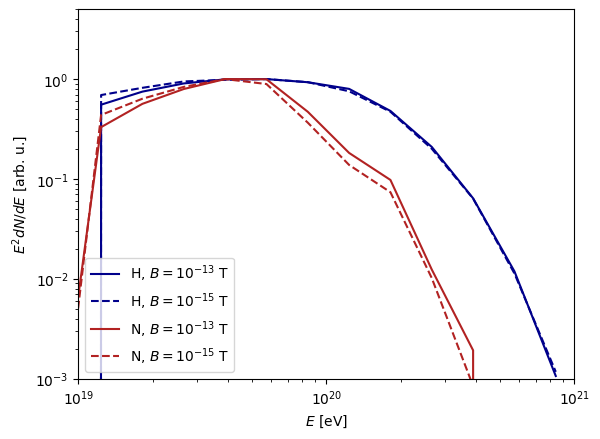

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

ls1, ls2 = '-', '--'
c1, c2 = 'darkblue', 'firebrick'

plt.plot(*spec1, ls = ls1, c = c1, label = 'H, $B = 10^{-13} \\; \\mathrm{T}$')
plt.plot(*spec2, ls = ls2, c = c1, label = 'H, $B = 10^{-15} \\; \\mathrm{T}$')
plt.plot(*spec3, ls = ls1, c = c2, label = 'N, $B = 10^{-13} \\; \\mathrm{T}$')
plt.plot(*spec4, ls = ls2, c = c2, label = 'N, $B = 10^{-15} \\; \\mathrm{T}$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e19, 1e21)
plt.ylim(1e-3, 5)
plt.ylabel('$E^2 dN/dE$ [arb. u.]')
plt.xlabel('$E$ [eV]')
plt.legend(loc = 'lower left')
plt.show()



### Plotting deflections

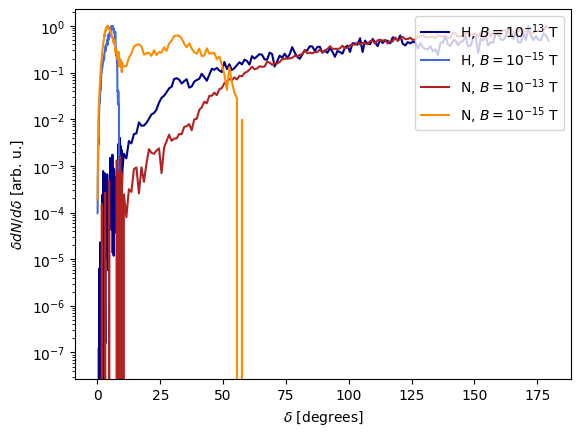

In [82]:
c1, c2 = 'darkblue', 'royalblue'
c3, c4 = 'firebrick', 'darkorange'
plt.plot(*defl1, c = c1, label = 'H, $B = 10^{-13} \\; \\mathrm{T}$')
plt.plot(*defl2, c = c2, label = 'H, $B = 10^{-15} \\; \\mathrm{T}$')
plt.plot(*defl3, c = c3, label = 'N, $B = 10^{-13} \\; \\mathrm{T}$')
plt.plot(*defl4, c = c4, label = 'N, $B = 10^{-15} \\; \\mathrm{T}$')
plt.yscale('log')
# plt.xlim(1e19, 1e21)
# plt.ylim(1e-3, 5)
plt.xlabel('$\\delta$ [degrees]')
plt.ylabel('$\\delta dN/d\\delta$ [arb. u.]')
plt.legend(loc = 'upper right')
plt.show()


### Plotting skymap

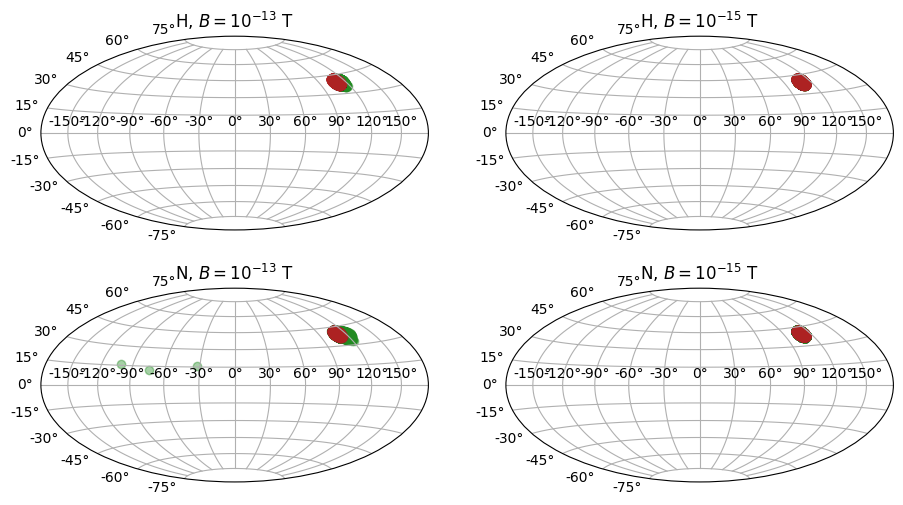

In [87]:
fig = plt.figure(figsize = (11, 6))
plotGrid = (2, 2)

c0 = 'black'
c1 = 'royalblue'
c2 = 'forestgreen'
c3 = 'firebrick'
Erange1 = '$1 \\leq E / EeV < 10$'
Erange2 = '$10 \\leq E / EeV < 100$'
Erange3 = '$100 \\leq E / EeV < 1000$'

opts_a = {'marker': 'o', 'c': c1, 'alpha': 0.6, 'label': Erange1}
opts_b = {'marker': 'o', 'c': c2, 'alpha': 0.4, 'label': Erange2}
opts_c = {'marker': 'o', 'c': c3, 'alpha': 0.2, 'label': Erange3}

ax = fig.add_subplot(*plotGrid, 1, projection = 'hammer')
ax.set_title('H, $B=10^{-13}$ T')
ax.grid(True)
ax.scatter(*arrDir1a, **opts_a)
ax.scatter(*arrDir1b, **opts_b)
ax.scatter(*arrDir1c, **opts_c)

ax = fig.add_subplot(*plotGrid, 2, projection = 'hammer')
ax.set_title('H, $B=10^{-15}$ T')
ax.grid(True)
ax.scatter(*arrDir2a, **opts_a)
ax.scatter(*arrDir2b, **opts_b)
ax.scatter(*arrDir2c, **opts_c)


ax = fig.add_subplot(*plotGrid, 3, projection = 'hammer')
ax.set_title('N, $B=10^{-13}$ T')
ax.grid(True)
ax.scatter(*arrDir3a, **opts_a)
ax.scatter(*arrDir3b, **opts_b)
ax.scatter(*arrDir3c, **opts_c)


ax = fig.add_subplot(*plotGrid, 4, projection = 'hammer')
ax.set_title('N, $B=10^{-15}$ T')
ax.grid(True)
ax.scatter(*arrDir4a, **opts_a)
ax.scatter(*arrDir4b, **opts_b)
ax.scatter(*arrDir4c, **opts_c)

print()


In [ ]:
p = [Vector3d(*ps) for ps in zip(data1['Px'], data1['Py'], data1['Pz'])]
print(p)

In [ ]:
np.amin(data1['Px'])